In [1]:
import xarray as xr
import pyfesom2 as pf
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pylab as plt

In [2]:
def interpolate_kdtree2d(
    data_in,
    x2,
    y2,
    lons,
    lats,
    distances,
    inds,
    radius_of_influence=50000,
    mask_zero=True,
):
    """Interpolates from points of unstructured mesh to regular grid.
    This version puts 0 where values are not present."""

    interpolated = data_in[inds]
    interpolated[distances >= radius_of_influence] = 0
    if mask_zero:
        interpolated[interpolated == 0] = np.nan
    interpolated.shape = lons.shape

    return interpolated

Load mesh:

In [3]:
mesh = pf.load_mesh('/work/ollie/projects/clidyn/FESOM2/meshes/core2/')

/work/ollie/projects/clidyn/FESOM2/meshes/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/projects/clidyn/FESOM2/meshes/core2/pickle_mesh_py3_fesom2


Prepear regular grid:

In [4]:
# lon = np.linspace(0.5, 359.5, 360)
# lat = np.linspace(-89.5, 89.5, 180)
# lon2, lat2 = np.meshgrid(lon, lat)
lon = np.linspace(0, 360, 360)
lat = np.linspace(-90, 90, 180)
lon2, lat2 = np.meshgrid(lon, lat)

Convert model longitude coordinates to [0..360] format

In [5]:
model_lon = np.where(mesh.x2<0, mesh.x2+360, mesh.x2)

Compute distances and indices fro neares neighbour interploation:

In [6]:
distances, inds = pf.create_indexes_and_distances(mesh, lon2, lat2, k=1)

Read data that we would like to interpolate:

In [7]:
ice_a = xr.open_dataset('/work/ollie/nkolduno/samuel/a_ice.fesom.1977.nc')
ice_m = xr.open_dataset('/work/ollie/nkolduno/samuel/m_ice.fesom.1977.nc')
ice_s = xr.open_dataset('/work/ollie/nkolduno/samuel/m_snow.fesom.1977.nc')

Interpolation for ice area. We take first time step. You might want to adjust radius_of_influence. We also put `mask_zero=False` to have 0 where we don't have sea ice.

In [16]:
a_interpolated = interpolate_kdtree2d(np.ma.filled(ice_a.a_ice[0,:].values, 0),
                                      model_lon, mesh.y2, lon2, lat2, distances, inds, mask_zero=False)

In [9]:
a_ice = xr.Dataset(
        {'a_ice': ([ "lat", "lon"], a_interpolated)},
        coords={
            "lat": (["lat"], lat),
            "lon": (["lon"], lon),
        },
    )

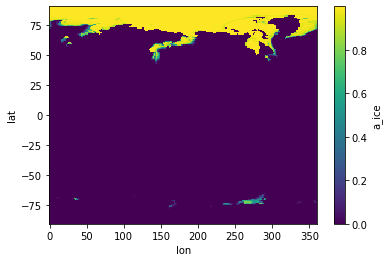

In [10]:
a_ice.a_ice.plot()

Save data:

In [11]:
a_ice.to_netcdf('a_ice2.nc')

Interpolation for sea ice thickness:

In [13]:
m_interpolated = interpolate_kdtree2d(np.ma.filled(ice_m.m_ice[0,:].values, 0),
                                      model_lon, mesh.y2, lon2, lat2, distances, inds, mask_zero=False)

In [14]:
m_ice = xr.Dataset(
        {'m_ice': ([ "lat", "lon"], m_interpolated)},
        coords={
            "lat": (["lat"], lat),
            "lon": (["lon"], lon),
        },
    )

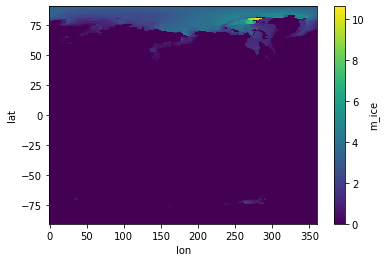

In [15]:
m_ice.m_ice.plot()

In [126]:
m_ice.to_netcdf('m_ice2.nc')

Interpolation of snow on sea ice.

In [128]:
s_interpolated = interpolate_kdtree2d(np.ma.filled(ice_s.m_snow[0,:].values, 0),
                                      model_lon, mesh.y2, lon2, lat2, distances, inds, mask_zero=False)

In [129]:
m_snow = xr.Dataset(
        {'m_snow': ([ "lat", "lon"], s_interpolated)},
        coords={
            "lat": (["lat"], lat),
            "lon": (["lon"], lon),
        },
    )

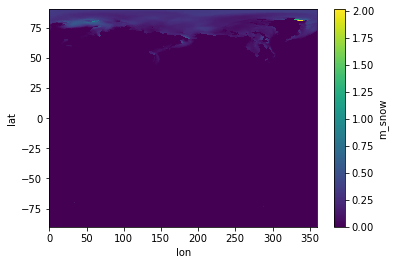

In [130]:
m_snow.m_snow.plot()

In [131]:
m_snow.to_netcdf('m_snow2.nc')